In [1]:
#头文件
import os
import numpy as np
import pandas as pd
import math
from pandas import DataFrame
from xml.etree import ElementTree as ET
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D
from keras.layers import *
from datetime import date
from keras.models import *
import tensorflow as tf 
os.environ['KERAS_BACKEND']='tensorflow'
os.environ['CUDA_VISIBLE_DEVICES']="0"
config=tf.compat.v1.ConfigProto() 
config.gpu_options.visible_device_list = '0' 
config.gpu_options.allow_growth = True 
config.gpu_options.per_process_gpu_memory_fraction = 0.7
sess=tf.compat.v1.Session(config=config)
#读取数据
dataset=[]
def data_load():
    path='./traffic-matrices'
    FileList = os.listdir(path)
    for files in FileList:
        oldDirPath = path+'/'+files
        per=ET.parse(oldDirPath)
        p=per.findall('./IntraTM/src')
        matrix=np.zeros((23,23))
        for child in p:
            src=child.attrib['id']
            c=child.findall('dst')
            for i in c:
                dst=i.attrib['id']
                matrix[int(src)-1][int(dst)-1]=i.text
        dataset.append(matrix)
    datasets = np.array(dataset)
    return datasets
datasets = data_load()
#二维流量矩阵转一维
data = []
for i in range(len(datasets)):
    arr = []
    for row in datasets[i]:
        arr.extend(row)
    data.append(arr)
data = np.array(data)
data = data[:,40]
#划分训练集和验证集
time_stamp = 100
train = data[6000:10600+time_stamp].reshape(-1,1)
valid = data[10600-time_stamp:-3].reshape(-1,1)
#归一化
scaler1 = MinMaxScaler(feature_range=(0, 1)) 
#训练集
scaled_data = scaler1.fit_transform(train)
x_train, y_train = [], []
for i in range(time_stamp, len(train)):
    x_train.append(scaled_data[i - time_stamp:i,0])
    y_train.append(scaled_data[i,0])
x_train,y_train= np.array(x_train),np.array(y_train)
y_train = y_train.reshape(-1,1)
#验证集
scaled_data2 = scaler1.transform(valid)
x_valid, y_valid = [], []
for i in range(time_stamp, len(valid)):
    x_valid.append(scaled_data2[i - time_stamp:i,0])
    y_valid.append(scaled_data2[i,0])
x_valid,y_valid = np.array(x_valid),np.array(y_valid)  
y_valid = y_valid.reshape(-1,1)
print(train.shape,x_train.shape,y_train.shape)

Using TensorFlow backend.


(4700, 1) (4600, 100) (4600, 1)


In [2]:
from sklearn.svm import SVR

clf = SVR(kernel='linear', C=1.25)
clf.fit(x_train, y_train)
y_hat = clf.predict(x_valid).reshape(1,-1)
# 反归一化
predict = scaler1.inverse_transform(y_hat)
true = scaler1.inverse_transform(y_valid)
#rmse
rmse= np.sqrt(np.mean(np.power((true - predict), 2)))
print(rmse)
mape = np.mean(np.abs((true - predict) / true)) * 100
print(mape)


32493.933561784957
53.04512716013758


D:\Program Files\Anaconda\envs\tensorflow-gpu\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


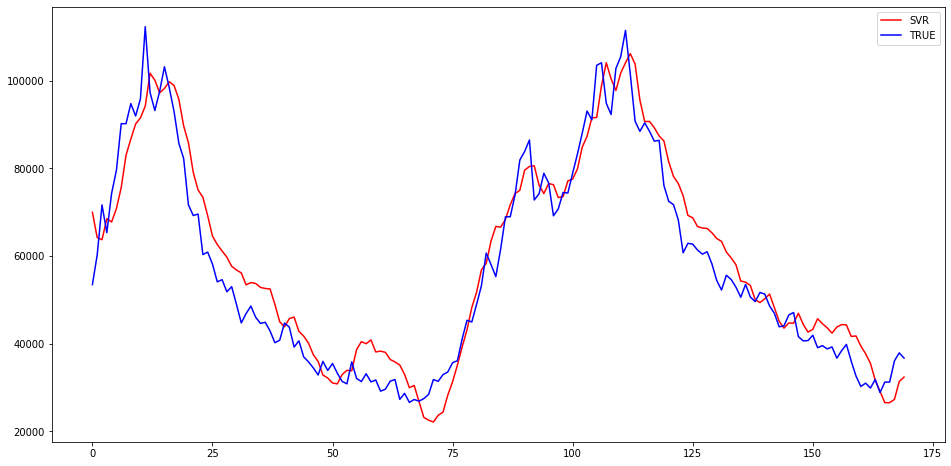

In [3]:
plt.figure(figsize=(16, 8))
predict = predict.reshape(1,-1)[0]
true = true.reshape(1,-1)[0]
plt.plot(np.arange(len(predict)),predict,label='SVR',color='r')
plt.plot(np.arange(len(true)),true,label='TRUE',color='b')
plt.legend()
plt.show()